In [1]:
import numpy as np
import cupy as cp

#import numpy as cp
#np = cp

import matplotlib.pyplot as plt
from PIL import Image

from load_dataset import load_dataset
from load_cached_weights import load_weights

import pandas as pd

from multiprocessing import Pool, cpu_count

In [2]:
# set path vars

#dataset_path = "C:\\Users\\user\\PycharmProjects\\my_cnn\\mnist_png"
dataset_path = 'mnist_png'
cached_weights_path = 'cache'

In [3]:
# activation functions and their derivatives

# sigmoid
def sigmoid(x):
    return 1/(1 + cp.exp(-x))

# sigmoid derivative
def sigmoid_d(x):
    return cp.exp(-x) / cp.power(1 + cp.exp(-x), 2.)

# ReLU
def relu(x):
    return cp.maximum(x, 0)

# ReLU derivative
def relu_d(x):
    x[x<=0] = 0
    x[x>0] = 1
    return x

# tanh
def tanh(x):
    return cp.tanh(x)

# tanh derivative
def tanh_d(x):
    return cp.power(cp.cosh(x), -2.)


# softmax
def s(x):
    shiftx = x - np.max(x)
    exps = np.exp(shiftx)
    return exps / np.sum(exps)

def softmax(x):
    slices = np.hsplit(cp.asnumpy(x), x.shape[1])
    p = Pool(cpu_count())
    concat = np.concatenate(list(p.map(s, slices)), axis=1)
    return cp.array(concat)


# TODO: softmax
# softmax_d
def softmax_d(x):
    # Reshape the 1-d softmax to 2-d so that np.dot will do the matrix multiplication
    def s_d(x):
        s = x.reshape(-1, 1)
        return cp.diagflat(s) - cp.dot(s, s.T)
    #return cp.apply_along_axis(s_d, 0, x)
    return cp.mean(
        cp.apply_along_axis(s_d, 0, x),
        axis=0
    )


# function to choose between the activation functions in place
def activation_function(Z, name, d=False):
    if d:
        if name == 'relu':
            return relu_d(Z)
        elif name == 'sigmoid':
            return sigmoid_d(Z)
        elif name == 'tanh':
            return tanh_d(Z)
        elif name == 'softmax':
            return softmax_d(Z)
    else:
        if name == 'relu':
            return relu(Z)
        elif name == 'sigmoid':
            return sigmoid(Z)
        elif name == 'tanh':
            return tanh(Z)
        elif name == 'softmax':
            return softmax(Z)


In [4]:
# load the MNIST dataset

dataset = load_dataset(dataset_path)
X = dataset['train']['X']
Y = dataset['train']['Y']

# convert X, Y to CuPy arrays

X = cp.array(X)#[:, :500]
Y = cp.array(Y)#[:, :500]

In [5]:
# load cached weights (if available)

cached_weights = load_weights(cached_weights_path)
weights = [cp.array(cached_weights['W'][W]) for W in sorted(cached_weights['W'].keys())]
biases = [cp.array(cached_weights['b'][b]) for b in sorted(cached_weights['b'].keys())]

In [6]:
# set the layer sizes

layer_sizes = [
    X.shape[0],
    32,
    Y.shape[0]
]

In [7]:
# set the activations

activations = [
    'relu',
    'softmax',
]

assert len(layer_sizes) == (len(activations) + 1)

In [8]:
def forward(X, weights, biases, activations):
    A = [X]
    for weight, bias, activation in zip(weights, biases, activations):
        Z = cp.dot(weight, A[-1]) + bias
        A.append(activation_function(Z, activation))

    return A

In [9]:
def backward(A, dAL, dZL, weights, activations):

    samples = A[0].shape[1]

    dA = [dAL]
    dZ = [dZL]
    dW = [cp.dot(dA[-1] * dZ[-1], A[-2].T) / samples]
    db = [cp.sum(dZ[-1], axis=1, keepdims=True) / samples]

    for index in range(1, len(weights)):
        da = cp.dot(weights[-index].T, dA[-1] * dZ[-1])

        dz = activation_function(A[-1-index],
                                     activations[-1-index],
                                     d=True)

        dW.append(cp.dot(da * dz, A[-2-index].T) / samples)
        db.append(cp.sum(dz, axis=1, keepdims=True) / samples)

        dA.append(da)
        dZ.append(dz)

    dW.reverse()
    db.reverse()

    return dW, db


In [10]:
def loss(predictions, actual, matrix=False):
    assert predictions.shape == actual.shape
    if matrix:
        return -(actual * cp.log(predictions))
    return -cp.sum(actual * cp.log(predictions))

In [82]:
# param init according to layer sizes
#   skip if cached ones are loaded

cp.random.seed(1337)

k = .5

weights = [cp.random.randn(layer_sizes[index], layer_sizes[index - 1]) * k  for index in range(1, len(layer_sizes))]
biases = [cp.zeros((layer_sizes[index], 1)) for index in range(1, len(layer_sizes))]

In [11]:
# train the model

iterations = 1
learning_rate = .04
stop_if_cost_goes_up = False

print_cost = True
print_at_i = 1

samples = X.shape[1] # number of training samples (60000 here)

costs = []

for i in range(1, iterations + 1):

    # forward propagation
    #   push input data through the network
    A = forward(X, weights, biases, activations)

    # Cross Entropy
    #   cost function, to compute the error
    cost = loss(A[-1], Y) / samples
    if i > 1 and stop_if_cost_goes_up:
        if not cost < costs[-1]:
            print(f'Cost went up @ i = {i}')
            break
    costs.append(float(cp.squeeze(cost)))
    if print_cost and i % print_at_i == 0:
        print(f'Cost: {cost} @ i = {i}')

    # backward propagation
    #   adjust the weights and biases to fit the data

    #   compute the derivatives of the weights and biases
    dAL = cp.ones(Y.shape)
    dZL = (A[-1] - Y)
    dW, db = backward(A, dAL, dZL, weights, activations)

    #   update the parameters
    weights = [weights[index] - learning_rate * dW[index] for index in range(len(weights))]
    biases = [biases[index] - learning_rate * db[index] for index in range(len(biases))]

Cost: 0.28815491710232966 @ i = 1


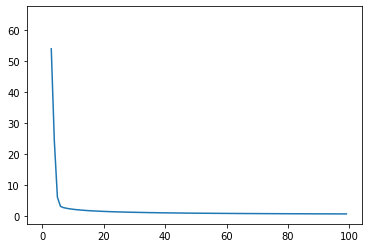

In [84]:
# plot the cost over time
plt.plot(range(len(costs)), costs)
plt.show()

0 [1.57016562e-15]
1 [5.43257913e-10]
2 [1.33037367e-08]
3 [0.99999979]
4 [1.63222344e-14]
5 [1.43341201e-08]
6 [1.99324058e-16]
7 [4.95013848e-10]
8 [1.82704152e-07]
9 [1.71874119e-09]
The system predicted:  3


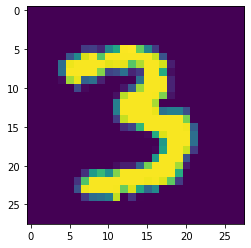

In [12]:
# load a sample image from the test dataset
# to evaluate the model

test_image_path = '3/500.png'

img = np.asarray(
        Image.open(
            dataset_path + "/testing/" + test_image_path
        )
    )
plt.imshow(img)
img = img.reshape((img.shape[0] * img.shape[1]))[:, cp.newaxis]

X_n = img

# regularize, then to CuPy
X_n = cp.array(X_n) / 255

# predict it
prediction = forward(X_n, weights, biases, activations)[-1]
[print(index, p)for index, p in enumerate(list(prediction))]
print('The system predicted: ', list(prediction).index(max(list(prediction))))

In [14]:
# validate

Y_prediction_train = forward(cp.array(dataset['train']['X']),
                            weights, biases, activations)[-1]
Y_train = cp.array(dataset['train']['Y'])


Y_prediction_test = forward(cp.array(dataset['test']['X']),
                            weights, biases, activations)[-1]
Y_test = cp.array(dataset['test']['Y'])

#print("train accuracy: {} %".format(100 - cp.mean(cp.abs(Y_prediction_train - Y_train)) * 100))
#print("test accuracy: {} %".format(100 - cp.mean(cp.abs(Y_prediction_test - Y_test)) * 100))

train_pred_indices = cp.argmax(Y_prediction_train, axis=0)
train_reference_indices = cp.argmax(Y_train, axis=0)

test_pred_indices = cp.argmax(Y_prediction_test, axis=0)
test_reference_indices = cp.argmax(Y_test, axis=0)

wrong_indices_train = cp.asnumpy((train_pred_indices != train_reference_indices).sum()).reshape(1)[0]
wrong_indices_test = cp.asnumpy((test_pred_indices != test_reference_indices).sum()).reshape(1)[0]

print("train accuracy: {} %".format(100 - (100 * wrong_indices_train / train_reference_indices.shape[0])))
print("test accuracy: {} %".format(100 - (100 * wrong_indices_test / test_reference_indices.shape[0])))

train accuracy: 97.35143466198888 %
test accuracy: 97.44375550628125 %
train accuracy: 92.13833333333334 %
test accuracy: 92.02 %


In [15]:
# save weights and biases

#weights_to_save = list(map(cp.asnumpy, weights.copy()))
#biases_to_save = list(map(cp.asnumpy, biases.copy()))

weights_to_save = weights.copy()
biases_to_save = biases.copy()

[pd.DataFrame(df).to_csv('cache/W/w{}.csv'.format(index + 1), index=False) for index, df in enumerate(weights_to_save)]

[pd.DataFrame(df).to_csv('cache/b/b{}.csv'.format(index + 1), index=False) for index, df in enumerate(biases_to_save)]


[None, None]